In [1]:
#make sure you are a the report /TFM directory, then we will create a report folder

In [2]:
!mkdir cl_rp

Ya existe el subdirectorio o el archivo cl_rp.


#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            explained_variance_score,recall_score,f1_score,precision_score,roc_curve,roc_auc_score,\
                            accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split,cross_validate
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
#import streamlit as st
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)



pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
# define the dataset location
# data will be located at root.
accidents = 'accidents_clean.csv'
cas_veh = 'df_merged_cat.csv'
path ='../../'

### Load data

In [5]:
#ORIGINAL
#dfa = pd.read_csv('../../Descargas/Stats19-Data1979-2004/Accidents7904.csv',delimiter=',',encoding='UTF-8-SIG',index_col=0)

In [6]:
# load the accidents_clean_csv file as a dataframe
dfa = pd.read_csv(path + accidents,delimiter=',',encoding='UTF-8-SIG',index_col=0)

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [7]:
# load the casualty_vehicle_csv file as a data frame
dfm = pd.read_csv(path + cas_veh,delimiter=',',encoding='UTF-8-SIG',index_col=0)

In [8]:
#Rename the column which will be used to have a merge.
dfa.rename(columns = {'Accident_Index':'Acc_Index'}, inplace = True)

In [9]:
#Merge the Accidents, casualties and vehicles dataframes cleaned from the last notebook.
dfmerged = pd.merge(dfa,dfm,how='inner',on= 'Acc_Index')

In [10]:
#dfmerged = dfmerged.loc[:1e6]

In [11]:
dfmerged.head()

,Acc_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Month,Year,Hour,Daytime,Road_Surface_Conditions_2,Weather_Conditions_2,Light_Conditions_2,Speed_limit_2,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Vehicle_Type,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle
0,198901AD00021,Slight,2,1,1989-01-02,Wednesday,A,Dual carriageway,30,January,1989,10,Office hours,Good,Good,Good,30-40,1,6,104,104,1,6,99,1,9
1,198901AD00021,Slight,2,1,1989-01-02,Wednesday,A,Dual carriageway,30,January,1989,10,Office hours,Good,Good,Good,30-40,1,6,104,108,1,8,2495,2,3
2,198901AD00022,Slight,2,1,1989-03-02,Friday,A,Dual carriageway,30,March,1989,11,Office hours,Good,Good,Good,30-40,1,6,104,104,1,6,249,1,7
3,198901AD00022,Slight,2,1,1989-03-02,Friday,A,Dual carriageway,30,March,1989,11,Office hours,Good,Good,Good,30-40,1,6,104,113,1,8,3858,2,8
4,198901AD00026,Slight,2,1,1989-08-02,Wednesday,A,Single carriageway,30,August,1989,17,Commuting to home,Good,Good,Good,30-40,1,6,104,104,1,6,392,1,10


In [12]:
#Drop useless columns
dfmerged.drop(columns=['Acc_Index', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date',
       'Road_Type','Month', 'Year', 'Hour','Speed_limit_2', 'Sex_of_Casualty',
       'Age_Band_of_Casualty', 'Casualty_Type','Propulsion_Code','1st_Road_Class'],inplace=True)

In [13]:
#delete old dataframes in order to have more RAM space for the next steps.
del dfa,dfm

## **Feature engineering**

In [14]:
## Processing numerical and categorical features.

In [15]:
num_cols = ['Age_of_Vehicle', 'Engine_Capacity_(CC)']
cat_cols = ['Day_of_Week', 'Speed_limit', 'Daytime',
       'Road_Surface_Conditions_2', 'Weather_Conditions_2',
       'Light_Conditions_2', 'Vehicle_Type', 'Sex_of_Driver',
       'Age_Band_of_Driver']

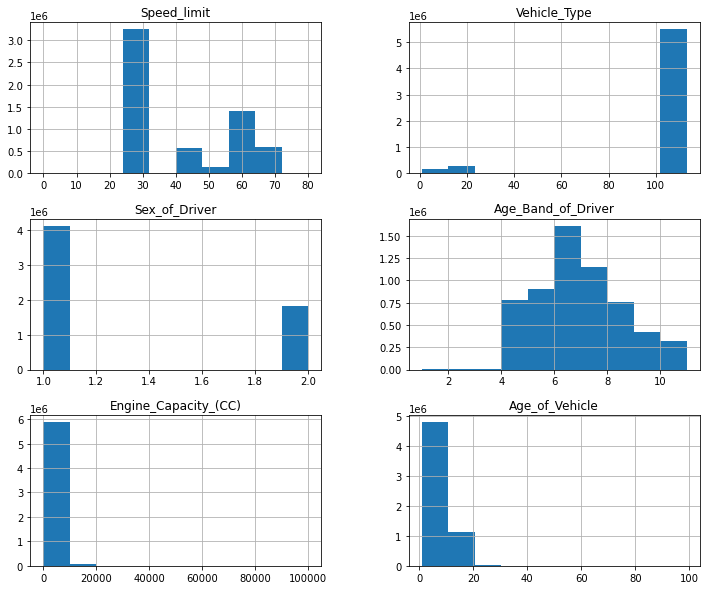

In [16]:
dfmerged.hist(figsize=(12,10));
#the two numerical variables doesn't have a normal distribution.
# We can also use a log tranform to check if the columns follow like a normal distribution

In [17]:
dfmerged['Age_of_Vehicle'] = dfmerged['Age_of_Vehicle'].replace(0,0.1)
dfmerged['Engine_Capacity_(CC)'] = dfmerged['Engine_Capacity_(CC)'].replace(0,0.1)
dfmerged['Age_of_Vehicle'] = dfmerged['Age_of_Vehicle'].apply(lambda x: np.log10(x))
dfmerged['Engine_Capacity_(CC)'] = dfmerged['Engine_Capacity_(CC)'].apply(lambda x: np.log10(x))

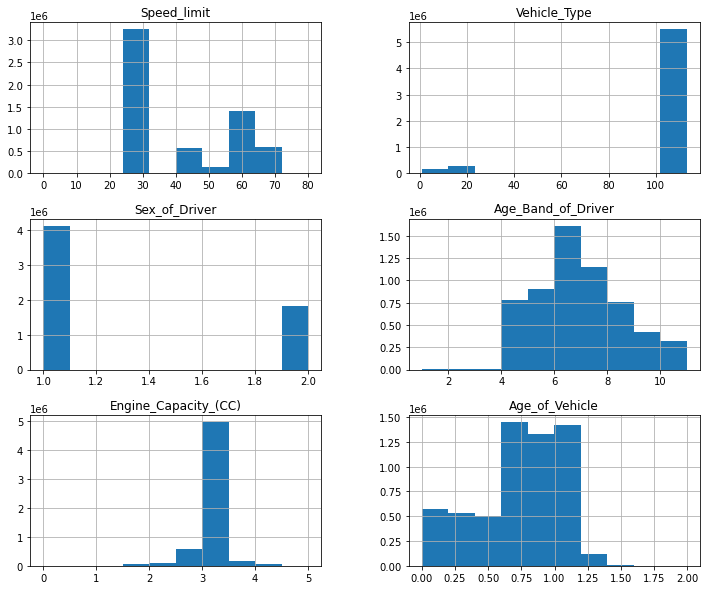

In [18]:
dfmerged.hist(figsize=(12,10));

In [19]:
# We can see that the distribution of Engine capacity and age of vehicle improves a little.

<AxesSubplot:xlabel='Engine_Capacity_(CC)'>

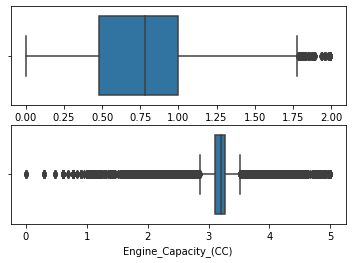

In [20]:
# plotting boxplots
fig,ax = plt.subplots(2,1)
sns.boxplot(data=dfmerged, x='Age_of_Vehicle',ax=ax[0])
sns.boxplot(data=dfmerged, x='Engine_Capacity_(CC)',ax=ax[1])


In [23]:
#check for NaN and missing values
print('NaN',dfmerged.isna().sum()/len(dfmerged))
np.abs(dfmerged[dfmerged == -1].sum())/len(dfmerged)

NaN Accident_Severity            0.0
Day_of_Week                  0.0
Speed_limit                  0.0
Daytime                      0.0
Road_Surface_Conditions_2    0.0
Weather_Conditions_2         0.0
Light_Conditions_2           0.0
Vehicle_Type                 0.0
Sex_of_Driver                0.0
Age_Band_of_Driver           0.0
Engine_Capacity_(CC)         0.0
Age_of_Vehicle               0.0
dtype: float64


Accident_Severity            0.0
Day_of_Week                  0.0
Speed_limit                  0.0
Daytime                      0.0
Road_Surface_Conditions_2    0.0
Weather_Conditions_2         0.0
Light_Conditions_2           0.0
Vehicle_Type                 0.0
Sex_of_Driver                0.0
Age_Band_of_Driver           0.0
Engine_Capacity_(CC)         0.0
Age_of_Vehicle               0.0
dtype: object

In [22]:
#change the variable types for categorial and numerical variables
for col in cat_cols:
    dfmerged[col] = dfmerged[col].astype('str')
    
for col in num_cols:
    dfmerged[col] = dfmerged[col].astype('int')

In [23]:
# Converting the target variable into numeric categories
dfmerged['Accident_Severity'].replace({'Slight': 1, 'Serious': 2, 'Fatal': 3}, inplace=True)
dfmerged['Accident_Severity'] = dfmerged['Accident_Severity'].astype('int64')

In [24]:
#Labelencoder

In [34]:
lenc = LabelEncoder()
dfmerged[cat_cols] = dfmerged[cat_cols].apply(lenc.fit_transform)
dfmerged['Accident_Severity'] = lenc.fit_transform(dfmerged['Accident_Severity'])

In [27]:
#This function calculates the Variance inflation factor and operates to drop the columns which VIF is greater than 5. Then it drops the variables with high collinearity

# URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [35]:
X = dfmerged.drop('Accident_Severity', axis=1)
y = dfmerged['Accident_Severity']

In [28]:
#Drop the columns with high collinerarity
X=calculate_vif(X)
#split before train our model
#X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

dropping 'Engine_Capacity_(CC)' at index: 9
dropping 'Vehicle_Type' at index: 6
dropping 'Age_Band_of_Driver' at index: 7
dropping 'Weather_Conditions_2' at index: 4
Remaining variables:
Index(['Day_of_Week', 'Speed_limit', 'Daytime', 'Road_Surface_Conditions_2',
       'Light_Conditions_2', 'Sex_of_Driver', 'Age_of_Vehicle'],
      dtype='object')


In [40]:
X.dtypes

Day_of_Week                  int32
Speed_limit                  int32
Daytime                      int32
Road_Surface_Conditions_2    int32
Weather_Conditions_2         int32
Light_Conditions_2           int32
Vehicle_Type                 int32
Sex_of_Driver                int32
Age_Band_of_Driver           int32
Engine_Capacity_(CC)         int32
Age_of_Vehicle               int32
dtype: object

In [28]:
cat = ['Day_of_Week','Daytime', 'Speed_limit','Road_Surface_Conditions_2',
       'Light_Conditions_2', 'Sex_of_Driver','Age_Band_of_Driver','Vehicle_Type','Weather_Conditions_2']

num  = ['Age_of_Vehicle','Engine_Capacity_(CC)']

In [29]:
import os
os.chdir('/GIT/TFM/')

import os
print(os.getcwd())

d:\GIT\TFM


In [47]:
#split before train our model
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

In [83]:
#This functions allow us to make predictions using different models.
def fit_pred_mod(select_model):
  #model selection 
    if select_model == 1:
        model = LogisticRegression(solver='lbfgs')
    elif select_model == 2:
        model = DecisionTreeClassifier()
    elif select_model == 3:
        model = RandomForestClassifier(n_jobs=-1)
    elif select_model == 4:
        model = BaggingClassifier()
        
    numeric_features = num
    categorical_features = cat
    #Handling categorical and numerical data with Pipelines
    numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

    #categorical_transformer = LabelEncoder()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    categorical_transformer  = StandardScaler()
    preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),])
        
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', model)])
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    eval_score(X_train, X_test, y_train, y_test, clf, yhat,select_model)

model score: 0.790


C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88   1172696
           1       0.57      0.00      0.00    270377
           2       0.00      0.00      0.00     41486

    accuracy                           0.79   1484559
   macro avg       0.45      0.33      0.29   1484559
weighted avg       0.73      0.79      0.70   1484559



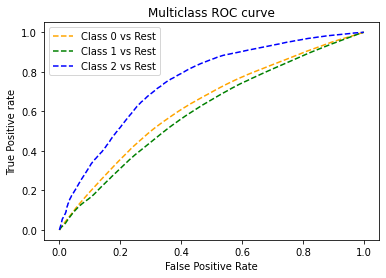

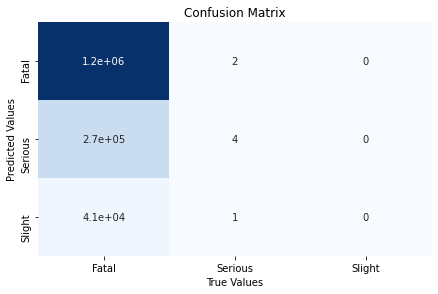

In [80]:
fit_pred_mod(2)

In [ ]:
#####################################################################################################################################################################

### **Defining functions**

In [86]:
def eval_score(X_train, X_test, y_train, y_test, classifier,yhat,select_model):
    classifier.fit(X_train, y_train)
#    preds = classifier.predict(X_test)
    probs = classifier.predict_proba(X_test)
    
    if select_model == 1:
        modelts = 'LogisticRegression'
    elif select_model == 2:
        modelts = 'DecisionTreeClassifier'
    elif select_model == 3:
        modelts = 'RandomForestClassifier'
    elif select_model == 4:
        modelts = 'BaggingClassifier'
          
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3
    print("model score: %.3f" % classifier.score(X_test, y_test))
    cr = classification_report(y_test, yhat)
    print(cr)
    
    f = open('cl_rp/report_'+modelts+'.txt', 'w')
    f.write('Classification Report {}\n\n{}'.format(modelts ,cr))
    f.close()
    
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('cl_rp/'+ modelts+'Multiclass ROC',dpi=300);
    
    #plotting matrix confusion
    matrix = confusion_matrix(y_test, yhat)
    dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                            columns=['Fatal', 'Serious', 'Slight'])
    # create heatmap
    fig,ax = plt.subplots()
    ax = sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
    ax = plt.title('Confusion Matrix')
    ax = plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
    plt.show()
    fig.savefig('cl_rp/' + modelts +'Confusion Matrix',dpi=300);

    return roc_auc_score(y_test, probs,multi_class='ovo', average='weighted')

In [81]:
#This functions allow us to make predictions using different models.

def evaluate_model(X,y,num,cat,select_model):
#selection model

    if select_model == 1:
        model = LogisticRegression(solver='lbfgs')
    elif select_model == 2:
        model = DecisionTreeClassifier()
    elif select_model == 3:
        model = RandomForestClassifier(n_jobs=-1)
    elif select_model == 4:
        model = BaggingClassifier()
        
         
    numeric_features = num
    categorical_features = cat
    #Handling categorical and numerical data with Pipelines
    numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    
#    categorical_transformer = LabelEncoder()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    categorical_transformer  = StandardScaler()
    preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
 
    ])

    # Append to classifier the preprocessing pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    
    eval_score(X_train, X_test, y_train, y_test, clf, yhat,select_model)
       
    return yhat

In [42]:
#evaluating Logistic Regresion model

model score: 0.790


C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88   1172696
           1       0.50      0.00      0.00    270377
           2       0.00      0.00      0.00     41486

    accuracy                           0.79   1484559
   macro avg       0.43      0.33      0.29   1484559
weighted avg       0.72      0.79      0.70   1484559



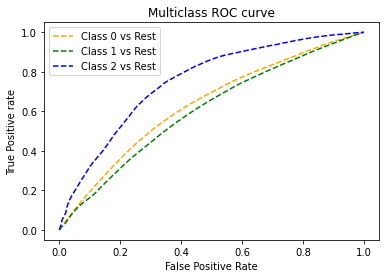

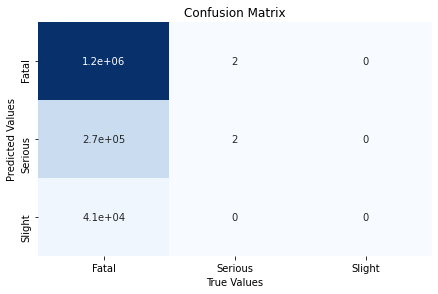

In [60]:
yhat = evaluate_model(X,y,num,cat,1)

In [70]:
'''def eval_score(X_train, X_test, y_train, y_test, classifier,yhat,select_model):
    classifier.fit(X_train, y_train)
#    preds = classifier.predict(X_test)
    probs = classifier.predict_proba(X_test)
    
    if select_model == 1:
        modelts = 'LogisticRegression'
    elif select_model == 2:
        modelts = 'DecisionTreeClassifier'
    elif select_model == 3:
        modelts = 'RandomForestClassifier'
    elif select_model == 4:
        modelts = 'BaggingClassifier'
    
    
    
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3
    print("model score: %.3f" % classifier.score(X_test, y_test))
    cr = classification_report(y_test, yhat)
    print(cr)
    
    f = open('report.txt', 'w')
    f.write('Classification Report {}\n\n{}'.format(modelts ,cr))
    f.close()
    
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig(modelts+'Multiclass ROC',dpi=300);
    
    #plotting matrix confusion
    matrix = confusion_matrix(y_test, yhat)
    dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                            columns=['Fatal', 'Serious', 'Slight'])
    # create heatmap
    fig,ax = plt.subplots()
    ax = sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
    ax = plt.title('Confusion Matrix')
    ax = plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
    plt.show()
    fig.savefig(modelts+'Confusion Matrix',dpi=300);




    return roc_auc_score(y_test, probs,multi_class='ovo', average='weighted')'''

'def eval_score(X_train, X_test, y_train, y_test, classifier,yhat,select_model):\n    classifier.fit(X_train, y_train)\n#    preds = classifier.predict(X_test)\n    probs = classifier.predict_proba(X_test)\n    \n    if select_model == 1:\n        modelts = \'LogisticRegression\'\n    elif select_model == 2:\n        modelts = \'DecisionTreeClassifier\'\n    elif select_model == 3:\n        modelts = \'RandomForestClassifier\'\n    elif select_model == 4:\n        modelts = \'BaggingClassifier\'\n    \n    \n    \n    # roc curve for classes\n    fpr = {}\n    tpr = {}\n    thresh ={}\n\n    n_class = 3\n    print("model score: %.3f" % classifier.score(X_test, y_test))\n    cr = classification_report(y_test, yhat)\n    print(cr)\n    \n    f = open(\'report.txt\', \'w\')\n    f.write(\'Classification Report {}\n\n{}\'.format(modelts ,cr))\n    f.close()\n    \n    for i in range(n_class):    \n        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)\n    # plottin

model score: 0.793
              precision    recall  f1-score   support

           0       0.80      0.99      0.88   1172696
           1       0.50      0.06      0.11    270377
           2       0.59      0.12      0.21     41486

    accuracy                           0.79   1484559
   macro avg       0.63      0.39      0.40   1484559
weighted avg       0.74      0.79      0.72   1484559



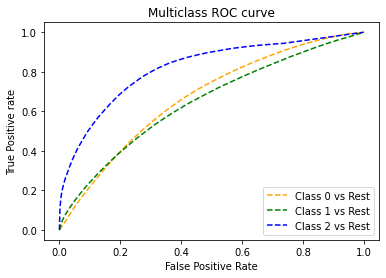

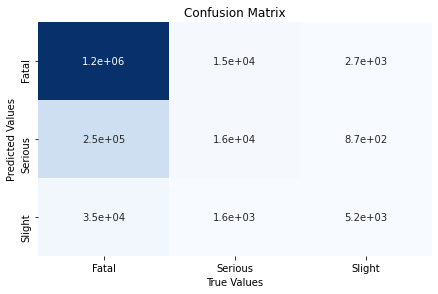

In [149]:
#Evaluating decisiontreeclassifier
yhat = evaluate_model(X,y,num,cat,2)

In [ ]:
#Evaluating randomforest classifier

model score: 0.794
              precision    recall  f1-score   support

           0       0.80      0.98      0.88   1172696
           1       0.51      0.06      0.11    270377
           2       0.61      0.13      0.22     41486

    accuracy                           0.79   1484559
   macro avg       0.64      0.39      0.41   1484559
weighted avg       0.74      0.79      0.73   1484559



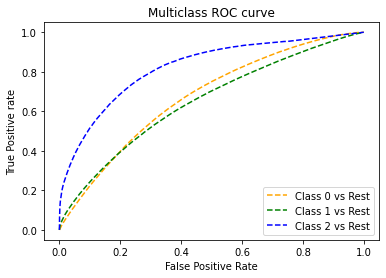

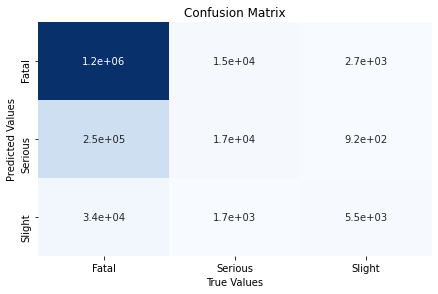

In [146]:
yhat = evaluate_model(X,y,num,cat,3)

model score: 0.793
              precision    recall  f1-score   support

           0       0.80      0.98      0.88   1172696
           1       0.50      0.07      0.12    270377
           2       0.59      0.13      0.22     41486

    accuracy                           0.79   1484559
   macro avg       0.63      0.39      0.41   1484559
weighted avg       0.74      0.79      0.73   1484559



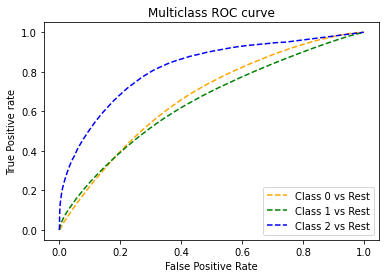

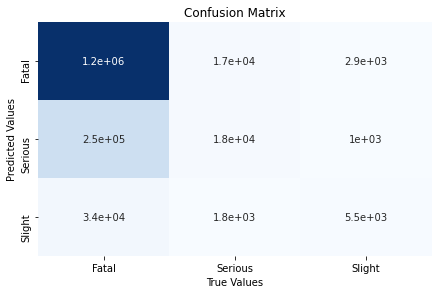

In [147]:
yhat = evaluate_model(X,y,num,cat,4)

In [117]:
    
    #THE LEARN CURVE TRAIN/TEST ERROR, OVERFIT UNDERFIT
lc = learning_curve(X,y)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of Good Fit Model")
plt.ylabel("Misclassification Rate/Loss");

TypeError: learning_curve() missing 1 required positional argument: 'y'

In [118]:
plot_learning_curves(X_train, y_train, X_test, y_test, clf)
plt.show()

NameError: name 'plot_learning_curves' is not defined